In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import LocalOutlierFactor

from NEExT.collections import EgonetCollection
from NEExT.io import GraphIO
from NEExT.datasets import GraphDataset

%reload_ext autoreload
%autoreload 2

In [2]:
from NEExT.outliers.benchmark_utils.data_loading import load_abcdo_data, load_pygod_data
from NEExT.outliers.benchmark_utils.embed import build_features
from NEExT.outliers.benchmark_utils.embed import build_embeddings
from NEExT.outliers.benchmark_utils.unsupervised import unsupervised_eval

graph_io = GraphIO()
k_hop = 1

# edges_df, mapping_df, features_df, ground_truth_df = load_pygod_data()
edges_df, mapping_df, features_df, ground_truth_df = load_abcdo_data()

graph_data = {
    "target": "is_outlier",
    "skip_features": [],
    "feature_list": [],
    # "feature_list": [i for i in features_df.columns[1:-1]],
}

In [3]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
egonet_collection = EgonetCollection(egonet_feature_target='is_outlier', skip_features=graph_data['skip_features'])
egonet_collection.compute_k_hop_egonets(graph_collection, k_hop)
structural_features, features = build_features(egonet_collection, feature_vector_length=k_hop, feature_list=graph_data["feature_list"])

In [4]:
embeddings = build_embeddings(
    egonet_collection,
    structural_features,
    features,
    strategy="structural_embeddings",
    embeddings_dimension=5,
    embeddings_algorithm="approx_wasserstein",
    # approx_wasserstein, wasserstein, sinkhornvectorizer
)
dataset = GraphDataset(egonet_collection, embeddings, standardize=False)

In [5]:
model = 'IF' # 'IF'

y_pred, score_mean, score_std, score_max = unsupervised_eval(model, ground_truth_df, dataset)  # noqa: F821
print(score_mean, score_std, score_max)

0.4833333333333334 0.010684067837465054 0.495625


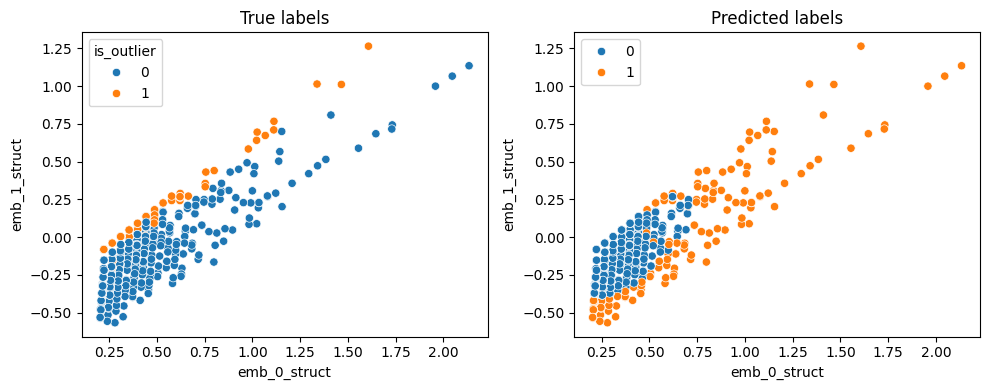

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=y_pred, ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


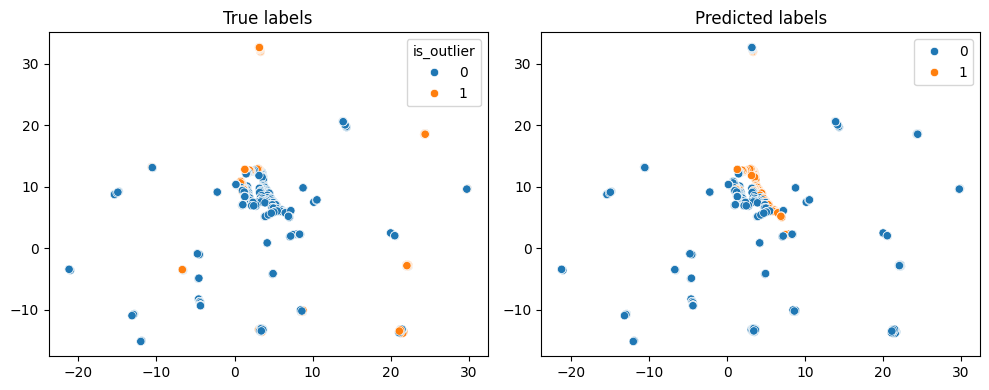

In [7]:
import umap

reduced = umap.UMAP().fit_transform(embeddings.embeddings_df.iloc[:, 1:])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=y_pred, ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()